In [ ]:
# connect to google drive, run this block again after every restart of runtime
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Outdoor_model_1112')

Mounted at /content/drive


In [ ]:
#!pip install tensorflow==2.9.0

In [ ]:
import os
import h5py
import time
import csv
import glob

import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras

from numpy import load
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import Conv3DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Multiply
from tensorflow.keras.layers import Lambda

from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import matplotlib
from matplotlib import pyplot
import matplotlib.pylab as plt
import seaborn as sns

In [ ]:
print(tf.__version__)

2.13.0


In [ ]:
# review (only review) GPU information, run when needed
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Sep 25 19:53:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# define an encoder block
def encoder_block(layer_in, n_filters, strd=(2,2,2), batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv3D(n_filters, (3,3,3), strides=strd, padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [ ]:
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, strd=(2,2,2), dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv3DTranspose(n_filters, (3,3,3), strides=strd, padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    # g = Activation('relu')(g)
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [ ]:
# define the standalone generator model
def define_generator(src_image_shape=(128,128,32,2)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=src_image_shape)

    # encoder model
    e0 = encoder_block(in_image, 128, strd=(1,1,1), batchnorm=True) # 128*128*32*128
    e1 = encoder_block(e0, 128, strd=(1,1,1), batchnorm=True) # 128*128*32*128
    e2 = encoder_block(e1, 128, strd=(1,1,1), batchnorm=True) # 128*128*32*128
    e3 = encoder_block(e2, 128, strd=(1,1,1), batchnorm=True) # 128*128*32*128
    e4 = encoder_block(e3, 128, strd=(1,1,1), batchnorm=True) # 128*128*32*128
    e5 = encoder_block(e4, 256, strd=(2,2,2), batchnorm=True) # 64*64*16*256
    e6 = encoder_block(e5, 256, strd=(1,1,1), batchnorm=True) # 64*64*16*256
    e7 = encoder_block(e6, 512, strd=(2,2,2), batchnorm=True) # 32*32*8*512
    e8 = encoder_block(e7, 512, strd=(1,1,1), batchnorm=True) # 32*32*8*512
    e9 = encoder_block(e8, 512, strd=(2,2,2), batchnorm=True) # 16*16*4*512
    e10 = encoder_block(e9, 512, strd=(1,1,1), batchnorm=True) # 16*16*4*512

    # bottleneck, no batch norm and relu
    b = Conv3D(512, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(e10) # 8*8*2*512
    b = LeakyReLU(alpha=0.2)(b)

    # decoder model
    d10 = Conv3DTranspose(512, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(b)  # 16*16*4*512
    d10 = BatchNormalization()(d10)
    d10 = Dropout(0.5)(d10)
    d10 = LeakyReLU(alpha=0.2)(d10)

    d9 = decoder_block(d10, e9, 512, strd=(1,1,1), dropout=True) # 16*16*4*1024

    d8 = Conv3DTranspose(512, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d9)  # 32*32*8*512
    d8 = BatchNormalization()(d8)
    d8 = Dropout(0.5)(d8)
    d8 = LeakyReLU(alpha=0.2)(d8)

    d7 = decoder_block(d8, e7, 512, strd=(1,1,1), dropout=True) # 32*32*8*1024

    d6 = Conv3DTranspose(256, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d7)  # 64*64*16*256
    d6 = BatchNormalization()(d6)
    d6 = Dropout(0.5)(d6)
    d6 = LeakyReLU(alpha=0.2)(d6)

    d5 = decoder_block(d6, e5, 256, strd=(1,1,1), dropout=True) # 64*64*16*512

    d4 = Conv3DTranspose(128, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d5) # 128*128*32*128
    d4 = BatchNormalization()(d4)
    d4 = Dropout(0.5)(d4)
    d4 = LeakyReLU(alpha=0.2)(d4)

    d3 = decoder_block(d4, e3, 128, strd=(1,1,1), dropout=True) # 128*128*32*256

    d2 = Conv3DTranspose(128, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d3) # 128*128*32*128
    d2 = BatchNormalization()(d2)
    d2 = Dropout(0.5)(d2)
    d2 = LeakyReLU(alpha=0.2)(d2)

    d1 = decoder_block(d2, e1, 128, strd=(1,1,1), dropout=True) # 128*128*32*256

    d0 = Conv3DTranspose(128, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d1) # 128*128*32*128
    d0 = BatchNormalization()(d0)
    d0 = Dropout(0.5)(d0)
    d0 = LeakyReLU(alpha=0.2)(d0)

    # output
    g = Conv3DTranspose(4, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d0) # 128*128*32*4
    out_image = Activation('tanh')(g)

    ######################################################################################
    mask = tf.repeat(in_image[:,:,:,:,1:], repeats=4, axis=-1)
    out_image = Multiply()([out_image, mask])
    ######################################################################################

    # define model
    model = Model(in_image, out_image)

    print("Generator Summary: \n")
    model.summary(positions = [.4, .68, .8, 1.])
    return model

In [ ]:
# dataset pipeline
def get_data_from_filename(filename):
    npdata = np.load(filename.numpy())
    uvw_scaler = 1/7.0
    p_scaler = 1/25.0
    bnd_mx, cfd_mx = npdata['arr_0'], npdata['arr_1']
    cfd_mx[:,:,:,0] *= uvw_scaler
    cfd_mx[:,:,:,1] *= uvw_scaler
    cfd_mx[:,:,:,2] *= uvw_scaler
    cfd_mx[:,:,:,3] *= p_scaler
    return bnd_mx, cfd_mx

def get_data_wrapper(filename):
    # Assuming here that both your data and label is float type.
    bnd_mx, cfd_mx = tf.py_function(get_data_from_filename, [filename], [tf.float32, tf.float32])
    return tf.data.Dataset.from_tensors((bnd_mx, cfd_mx))

def set_shape(m1, m2):
    m1.set_shape((128, 128, 32, 2))
    # m1 = tf.expand_dims(m1, axis=-1)
    m2.set_shape((128, 128, 32, 4))
    return m1, m2

# Create dataset of filenames.
test_percent = 0.01
batch_size = 2
npz_folder_path = "/content/drive/MyDrive/Outdoor_model_1112/Outdoor_Dataset"
filelist = glob.glob(npz_folder_path + '/*.npz')
train_num = int((len(filelist)/batch_size)*(1.0-test_percent))
print("number of data point in training set: ", train_num)
ds = tf.data.Dataset.from_tensor_slices(filelist)
ds = ds.flat_map(get_data_wrapper)
ds = ds.map(set_shape)
ds = ds.batch(batch_size)
ds_train = ds.take(train_num)
ds_test = ds.skip(train_num)

number of data point in training set:  2376


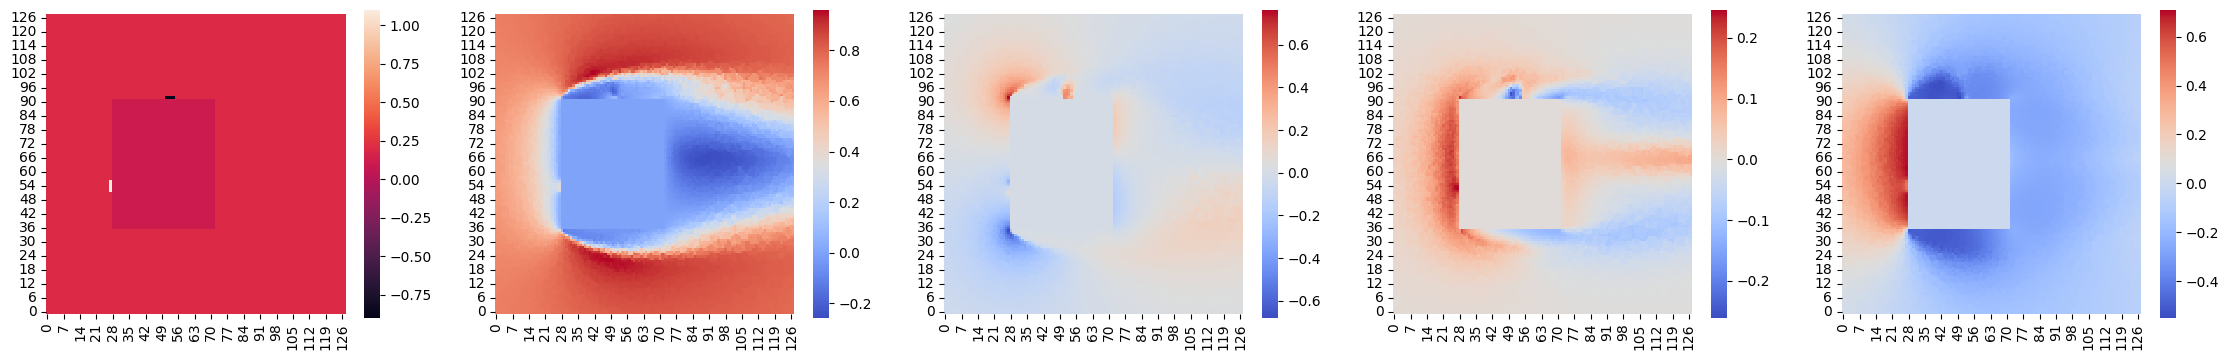

In [ ]:
# print data example
z = 6
for bnd_mx, cfd_mx in ds_test.skip(8).take(1):
    u, v, w, p = cfd_mx.numpy()[0,:,:,:,0], cfd_mx.numpy()[0,:,:,:,1], cfd_mx.numpy()[0,:,:,:,2], cfd_mx.numpy()[0,:,:,:,3]

    u_min, u_max = np.amin(u[:,:,z], axis=(0,1)), np.amax(u[:,:,z], axis=(0,1))
    v_min, v_max = np.amin(v[:,:,z], axis=(0,1)), np.amax(v[:,:,z], axis=(0,1))
    w_min, w_max = np.amin(w[:,:,z], axis=(0,1)), np.amax(w[:,:,z], axis=(0,1))
    p_min, p_max = np.amin(p[:,:,z], axis=(0,1)), np.amax(p[:,:,z], axis=(0,1))

    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(28, 4))
    sns.heatmap(bnd_mx.numpy()[0,:,:,z,0].T, ax = ax[0], square = True)
    ax[0].invert_yaxis()
    sns.heatmap(u[:,:,z].T, ax = ax[1], square = True, cmap="coolwarm", vmin=u_min, vmax=u_max)
    ax[1].invert_yaxis()
    sns.heatmap(v[:,:,z].T, ax = ax[2], square = True, cmap="coolwarm", vmin=v_min, vmax=v_max)
    ax[2].invert_yaxis()
    sns.heatmap(w[:,:,z].T, ax = ax[3], square = True, cmap="coolwarm", vmin=w_min, vmax=w_max)
    ax[3].invert_yaxis()
    sns.heatmap(p[:,:,z].T, ax = ax[4], square = True, cmap="coolwarm", vmin=p_min, vmax=p_max)
    ax[4].invert_yaxis()

In [ ]:
generator = define_generator()
generator_optimizer = Adam(0.000002, beta_1=0.9) # lr 0.0002 ep 50 0.00002 ep 100 0.000002

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Generator Summary: 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #     Connected to        
 input_1 (InputLayer)                  [(None, 128, 128, 32, 2)   0           []                  
                                       ]                                                          
                                                                                                  
 conv3d (Conv3D)                       (None, 128, 128, 32, 128   7040        ['input_1[0][0]']   
                                       )                                                          
                                                                                                  
 batch_normalization (BatchNormalizat  (None, 128, 128, 32, 128   512         ['conv3d[0][0]']    
 ion)                                  )                                 

In [ ]:
@tf.function
def resnet_train_iteration(bnd, cfd):
    with tf.GradientTape() as gen_tape:
        generated_images = generator(bnd, training=True)
        # gen_loss = MeanAbsoluteError()(generated_images, cfd)
        loss_factor = 10.0
        mae = MeanAbsoluteError()(generated_images, cfd, sample_weight=K.abs(tf.subtract(bnd[:,:,:,:,0], 0.1))) * loss_factor
        prop = tf.math.reduce_mean(bnd[:,:,:,:,1])
        gen_loss = tf.math.divide(mae, prop)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss

In [ ]:
def train(dataset, epochs, starting_epoch):
    f = open("/content/drive/MyDrive/Outdoor_model_1112/Outdoor_model_loss_0801_" + str(starting_epoch) + ".csv", "w")
    writer = csv.writer(f)
    writer.writerow(list(range(train_num)))
    f.close()

    for epoch in range(epochs):
        train_loss = []
        start = time.time()
        for i, (bnd_mx, cfd_mx) in enumerate(dataset):
            gen_loss = resnet_train_iteration(bnd_mx, cfd_mx)
            print('>%d, g[%.5f]' % (i+1, gen_loss))
            train_loss.append(gen_loss.numpy())
        with open('/content/drive/MyDrive/Outdoor_model_1112/Outdoor_model_loss_0801_' + str(starting_epoch) + '.csv', 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(train_loss)

        # save the model every 5 epochs
        if (epoch+1) % 5 == 0:
            g_filename = '/content/drive/MyDrive/Outdoor_model_1112/Archive_model/0801/Outdoor_model_0801_%06d.h5' % (starting_epoch+epoch+1)
            generator.save(g_filename)
            print('>save g_model: %s' % (g_filename))

        print('Time for epoch {} is {} sec'.format(starting_epoch + epoch + 1, time.time()-start))

In [ ]:
train(ds_train, epochs=50, starting_epoch=150)

In [ ]:
g_filename = "/content/drive/MyDrive/Outdoor_model_1112/Archive_model/0801/Outdoor_model_0801_000150.h5"
generator = load_model(g_filename, compile=False)

In [ ]:
batch_ind = 8

for bnd_mx, cfd_mx in ds_test.skip(batch_ind).take(1):
# for bnd_mx, cfd_mx in ds_train.skip(batch_ind).take(1):
    pred_mx = generator.predict(bnd_mx)

1/1 [==============================] - 13s 13s/step


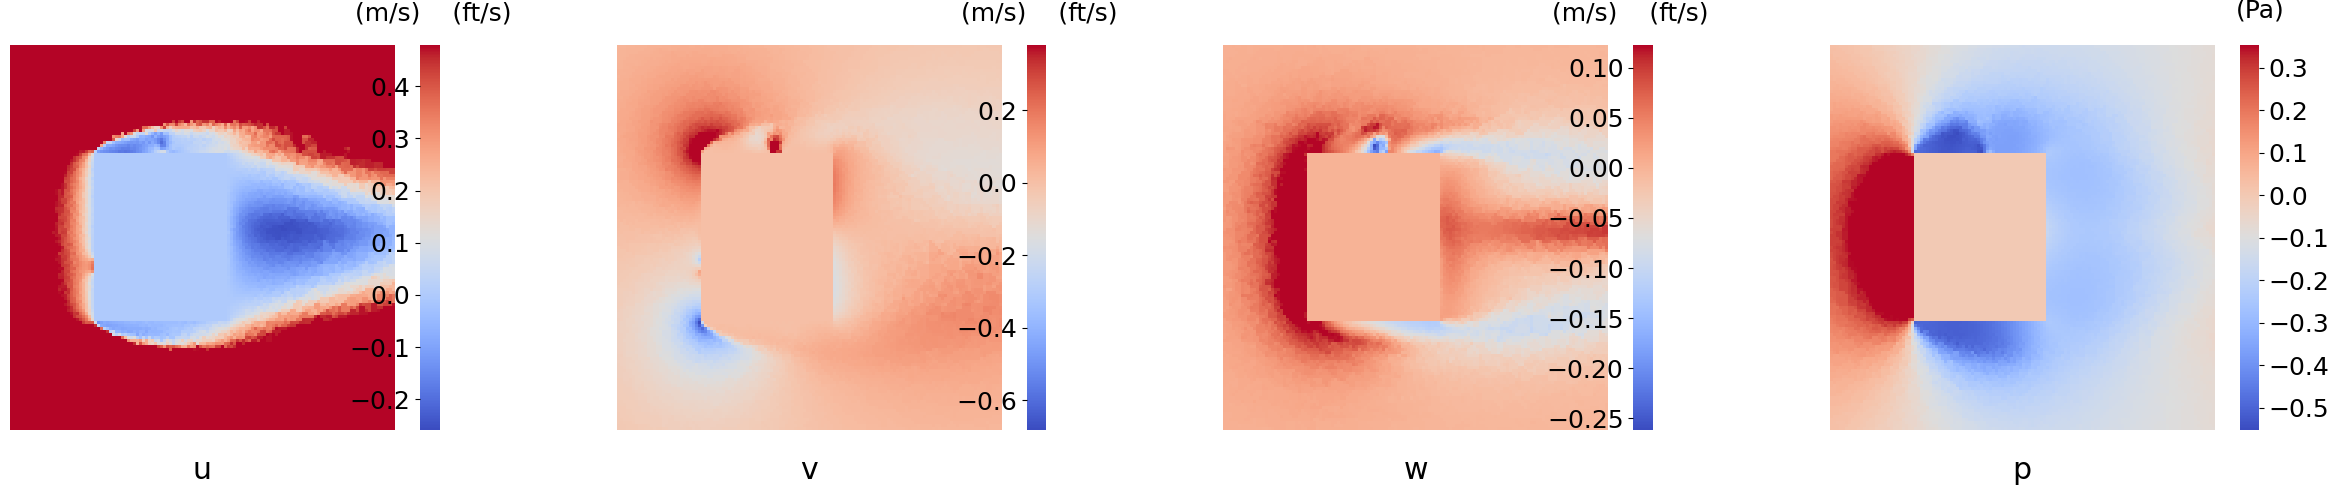

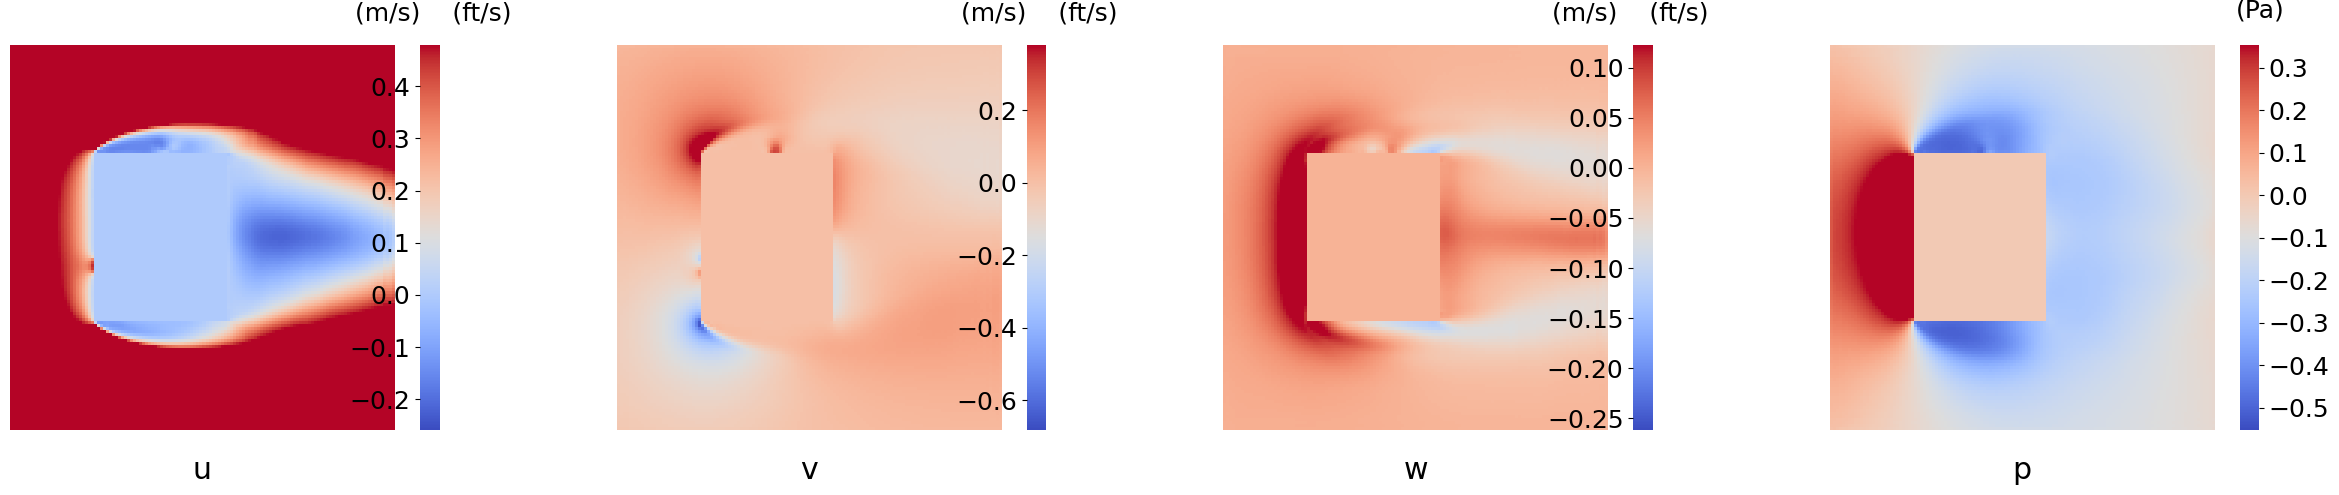

In [ ]:
z = 6 # 0~16
matplotlib.rcParams.update({'font.size': 18})

u_min, u_max = np.amin(cfd_mx[0,:,:,z,0], axis=(0,1)), np.amax(cfd_mx[0,:,:,z,0]/2.0, axis=(0,1))
v_min, v_max = np.amin(cfd_mx[0,:,:,z,1], axis=(0,1)), np.amax(cfd_mx[0,:,:,z,1]/2.0, axis=(0,1))
w_min, w_max = np.amin(cfd_mx[0,:,:,z,2], axis=(0,1)), np.amax(cfd_mx[0,:,:,z,2]/2.0, axis=(0,1))
p_min, p_max = np.amin(cfd_mx[0,:,:,z,3], axis=(0,1)), np.amax(cfd_mx[0,:,:,z,3]/2.0, axis=(0,1))
bnds = [[u_min, u_max], [v_min, v_max], [w_min, w_max], [p_min, p_max]]
uvw = ["u", "v", "w"]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 5))
for i in range(3):
    ax[i] = sns.heatmap(cfd_mx.numpy()[0,:,:,z,i].T, ax = ax[i], square = True, cmap="coolwarm", vmin=bnds[i][0], vmax=bnds[i][1])
    ax[i].invert_yaxis()
    ax[i].axis('off')
    ax[i].set_title(uvw[i], y=-0.15)
    ax[i].collections[0].colorbar.ax.locator_params(nbins=10)
    cbar0 = ax[i].collections[0].colorbar

    # pos = cbar0.ax.get_position()
    # print(cbar0.ax.get_yticks())
    # print(cbar0.ax.get_ylim())
    # newpos = np.interp(cbar0.ax.get_yticks(), cbar0.ax.get_ylim(), cbar0.clim())
    # newlabel = (newpos*3.28084).round(2)

    # pos.x0 += 0.02
    # pos.x1 += 0.02

    ax1 = cbar0.ax
    ax1.set_aspect('auto')

    # ax1.set_position(pos)

    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_label_position('left')
    ax1.set_ylabel('(m/s)    (ft/s)', rotation=0, labelpad=-60, y=1.05)

    # ax2 = ax1.twinx()
    # ax2.set_position(pos)
    # ax2.set_ylim([bnds[i][0], bnds[i][1]])
    # ax2.yaxis.set_ticks_position('right')
    # ax2.yaxis.set_label_position('right')
    # ax2.set_yticks(newpos)
    # ax2.set_yticklabels(newlabel)

ax[3] = sns.heatmap(cfd_mx.numpy()[0,:,:,z,3].T, ax = ax[3], square = True, cmap="coolwarm", vmin=p_min, vmax=p_max)
ax[3].invert_yaxis()
ax[3].axis('off')
ax[3].set_title("p", y=-0.15)

# ax[3].collections[0].colorbar.outline.set_visible(True)

cbar3 = ax[3].collections[0].colorbar
cbar3.ax.set_ylabel('(Pa)', rotation=0, labelpad=-50, y=1.12)
cbar3.ax.locator_params(nbins=10)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 5))
pred_mx = np.multiply(pred_mx, bnd_mx[:,:,:,:,1:2])
for i in range(3):
    ax[i] = sns.heatmap(pred_mx[0,:,:,z,i].T, ax = ax[i], square = True, cmap="coolwarm", vmin=bnds[i][0], vmax=bnds[i][1])
    ax[i].invert_yaxis()
    ax[i].axis('off')
    ax[i].set_title(uvw[i], y=-0.15)
    ax[i].collections[0].colorbar.ax.locator_params(nbins=10)
    cbar0 = ax[i].collections[0].colorbar

    # pos = cbar0.ax.get_position()
    # newpos = np.interp(cbar0.ax.get_yticks(), cbar0.ax.get_ylim(), cbar0.get_clim())
    # newlabel = (newpos*3.28084).round(2)

    # pos.x0 += 0.02
    # pos.x1 += 0.02

    ax1 = cbar0.ax
    ax1.set_aspect('auto')

    # ax1.set_position(pos)

    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_label_position('left')
    ax1.set_ylabel('(m/s)    (ft/s)', rotation=0, labelpad=-60, y=1.05)

    # ax2 = ax1.twinx()
    # ax2.set_position(pos)
    # ax2.set_ylim([bnds[i][0], bnds[i][1]])
    # ax2.yaxis.set_ticks_position('right')
    # ax2.yaxis.set_label_position('right')
    # ax2.set_yticks(newpos)
    # ax2.set_yticklabels(newlabel)

ax[3] = sns.heatmap(pred_mx[0,:,:,z,3].T, ax = ax[3], square = True, cmap="coolwarm", vmin=p_min, vmax=p_max)
ax[3].invert_yaxis()
ax[3].axis('off')
ax[3].set_title("p", y=-0.15)
cbar3 = ax[3].collections[0].colorbar
cbar3.ax.set_ylabel('(Pa)', rotation=0, labelpad=-50, y=1.12)
cbar3.ax.locator_params(nbins=10)

In [ ]:
csv_file_pth = "/content/drive/MyDrive/Outdoor_model_1112/Outdoor_model_loss_0801_50.csv"
df = pd.read_csv(csv_file_pth)
df

,0,1,2,3,4,5,6,7,8,9,...,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187
0,0.011617,0.010910,0.009431,0.008803,0.009434,0.010799,0.009987,0.010698,0.009168,0.010066,...,0.009712,0.008240,0.009350,0.009766,0.008261,0.009320,0.008509,0.010666,0.009895,0.009033
1,0.010048,0.009689,0.008396,0.007644,0.009281,0.010667,0.009454,0.010257,0.008946,0.009215,...,0.009443,0.008203,0.009210,0.009395,0.008411,0.009226,0.008613,0.010648,0.010006,0.008941
2,0.009658,0.009805,0.008366,0.007397,0.008984,0.010467,0.009425,0.010303,0.008914,0.009281,...,0.009419,0.008172,0.009130,0.009353,0.008184,0.009270,0.008505,0.010423,0.010019,0.008859
3,0.009696,0.009809,0.008224,0.007457,0.008894,0.010600,0.009391,0.010260,0.009012,0.009149,...,0.009459,0.008208,0.009260,0.009359,0.008414,0.009093,0.008655,0.010322,0.010138,0.008853
4,0.009607,0.009686,0.008307,0.007569,0.009005,0.010483,0.009309,0.010181,0.009136,0.009139,...,0.009436,0.008192,0.009082,0.009344,0.008163,0.009197,0.008390,0.010228,0.009779,0.008991
5,0.009678,0.009465,0.008343,0.007375,0.008852,0.010289,0.009276,0.010043,0.008810,0.009178,...,0.009408,0.007953,0.008999,0.009299,0.008312,0.009031,0.008322,0.010018,0.009883,0.008661
6,0.009434,0.009490,0.008274,0.007326,0.008755,0.010392,0.009286,0.010022,0.008890,0.009269,...,0.009245,0.008243,0.009049,0.009253,0.008015,0.009065,0.008317,0.010042,0.009890,0.008644
7,0.009608,0.009474,0.008150,0.007297,0.008861,0.010162,0.009239,0.009950,0.008824,0.008970,...,0.009227,0.007950,0.009107,0.009212,0.008046,0.009042,0.008443,0.010215,0.009767,0.008453
8,0.009332,0.009394,0.008154,0.007359,0.008888,0.010105,0.009306,0.009853,0.008791,0.008943,...,0.009108,0.008019,0.009181,0.009098,0.007965,0.009001,0.008681,0.009887,0.009721,0.008700
9,0.009327,0.009294,0.008012,0.007319,0.008727,0.010225,0.009210,0.009734,0.008587,0.009142,...,0.009221,0.007918,0.009012,0.009155,0.008040,0.008937,0.008342,0.009875,0.009796,0.008540


0     0.009598
1     0.009378
2     0.009300
3     0.009221
4     0.009160
5     0.009114
6     0.009069
7     0.009030
8     0.008992
9     0.008957
10    0.008915
11    0.008886
12    0.008859
13    0.008832
14    0.008798
15    0.008772
16    0.008753
17    0.008735
18    0.008709
dtype: float64


<Axes: >

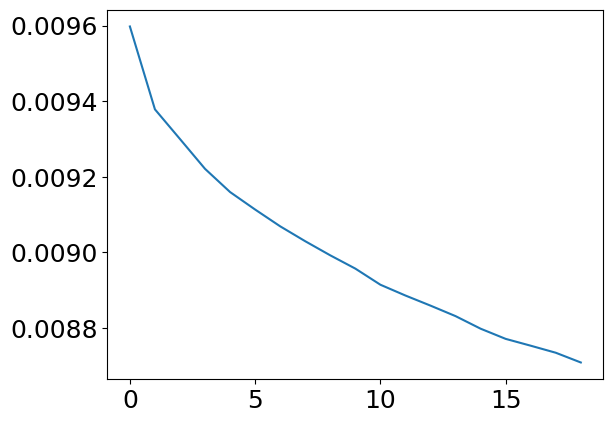

In [ ]:
print(df.mean(axis=1))
df.mean(axis=1).plot()

In [ ]:
# tensorflow approach ==========================================
# Create test dataset 600
test_batch_size = 2
test_folder_path = "/content/drive/MyDrive/Outdoor_model_1112/Outdoor_Test_Dataset"
test_600_filelist = sorted(glob.glob(test_folder_path + '/*.npz'), key = lambda path: int(path.replace(".npz","").split("outdoor_iteration_")[1]))
print(len(test_600_filelist))
ds_600_test = tf.data.Dataset.from_tensor_slices(test_600_filelist)
ds_600_test = ds_600_test.flat_map(get_data_wrapper)
ds_600_test = ds_600_test.map(set_shape)
ds_600_test = ds_600_test.batch(batch_size)

600


In [ ]:
# tensorflow approach ==========================================
epoch_list = range(5, 155, 5)
mean_loss_list = []
for k in epoch_list:
    start = time.time()
    g_filename = '/content/drive/MyDrive/Outdoor_model_1112/Archive_model/0801/Outdoor_model_0801_%06d.h5' % (k)
    model = load_model(g_filename, compile=False)
    loss_list = []
    for i, (bnd, cfd) in enumerate(ds_600_test):
        generated_images = model.predict(bnd)
        loss_factor = 10.0
        mae = MeanAbsoluteError()(generated_images, cfd, sample_weight=K.abs(tf.subtract(bnd[:,:,:,:,0], 0.1))) * loss_factor
        prop = tf.math.reduce_mean(bnd[:,:,:,:,1])
        gen_loss = tf.math.divide(mae, prop)
        loss_list.append(gen_loss.numpy())
    mean_loss_list.append(np.mean(loss_list))
    print('Time for epoch {} is {} sec'.format(k, time.time()-start))
df = pd.DataFrame({"epoch": epoch_list, "loss": mean_loss_list})
df.to_csv("/content/drive/MyDrive/Outdoor_model_1112/Outdoor_test_loss_0801.csv", index=False)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
Time for epoch 70 is 99.87228989601135 sec
1/1 [==============================] - 0s 27ms/step
Time for epoch 75 is 101.37851691246033 sec
1/1 [==============================] - 0s 26ms/step
Time for epoch 80 is 99.16427755355835 sec
1/1 [==============================] - 0s 26ms/step
Time for epoch 85 is 95.69390320777893 sec
1/1 [==============================] - 0s 26ms/step
Time for epoch 90 is 95.22973394393921 sec
1/1 [==============================] - 0s 27ms/step
Time for epoch 95 is 98.30757212638855 sec
1/1 [==============================] - 0s 26ms/step
Time for epoch 100 is 100.28810954093933 sec
1/1 [==============================] - 0s 31ms/step
Time for epoch 105 is 99.43268823623657 sec
1/1 [==============================] - 0s 26ms/step
Time for epoch 110 is 95.87909436225891 sec
1/1 [==============================] - 0s 26ms/step
Time for epoch 115 is 99.140867471694

Text(0.5, 1.0, 'Testing Loss Trajectory')

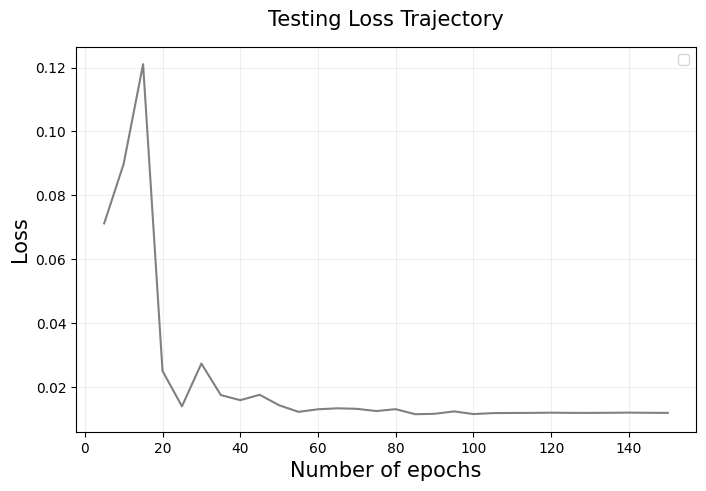

In [ ]:
df_test_lost = pd.read_csv("/content/drive/MyDrive/Outdoor_model_1112/Outdoor_test_loss_0801.csv")

plt.figure(figsize = (8, 5))
plt.plot(df_test_lost.epoch, df_test_lost.loss, color='grey')
plt.grid(alpha=0.2)
plt.legend(loc='upper right')
plt.grid(alpha=0.2)
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('Testing Loss Trajectory', fontsize=15, pad = 15)